# 10.2 문장 임베딩 방식
- 텍스트를 활용할 때 단어 단위보다 문장, 문단 같은 더 큰 단위를 사용
- 여러 단어가 합쳐진 문장을 임베딩 벡터로 변환하는 방법이 필요

## 10.2.1 문장 사이의 관계를 계산하는 두 가지 방법
- BERT(Bidirectional Encoder Representations from Transformers)와 같은 트랜스포머 기반 모델은 문장 임베딩을 계산하는 데 사용되는 대표적인 모델

![image.png](resources/sentence-encoder.png)

### 바이 인코더(bi-encoder)
- 각각의 문장을 독립적으로 BERT 모델에 입력 (문장 A, B)
- 풀링 층은 문장의 길이가 달라져도 문장 임베딩의 차원이 같도록 맞춰주는 층
- 출력 결과인 문장 임베딩 벡터(u, v)를 계산
- 코사인 유사도와 같은 별도의 계산 방식을 통해 유사도 계산

### 교차 인코더(cross-encoder)
- 문장 A와 B를 함께 입력
- 출력결과 자체가 유사도
- 바이 인코더 방식에 비해 계산량이 많지만, 두 문장의 상호작용을 고려할 수 있어 좀 더 정확한 관계 예측이 가능
- 하지만 입력으로 넣은 두 문장의 유사도만 계산하기 때문에 다른 문장과 검색 쿼리의 유사도를 알고 싶으면 다시 동일한 연산을 반복 (p.339~341)


### 유사도 계산 방식

- 유클리드 거리: 두 벡터 사이의 직선 거리를 계산합니다.

    ![image.png](resources/euclidean.png)
- 코사인 유사도: 두 벡터 사이의 각도를 기반으로 유사도를 측정합니다. (0과 1 사이의 값을 가집니다.)

    ![image.png](resources/cosine.png)

## 10.2.2 바이 인코더 모델 구조
- BERT 모델의 출력을 풀링 층을 통해 고정된 크기의 문장 임베딩으로 만든다.
    - BERT 모델은 입력 토큰마다 출력 임베딩을 생성
    - 입력하는 문장의 길이가 달라질 경우, 출력하는 임베딩의 수가 달라진다.
    - 문맥이 반영된 단어 임베딩은 position encoding + self-attention을 통해 문맥을 반영

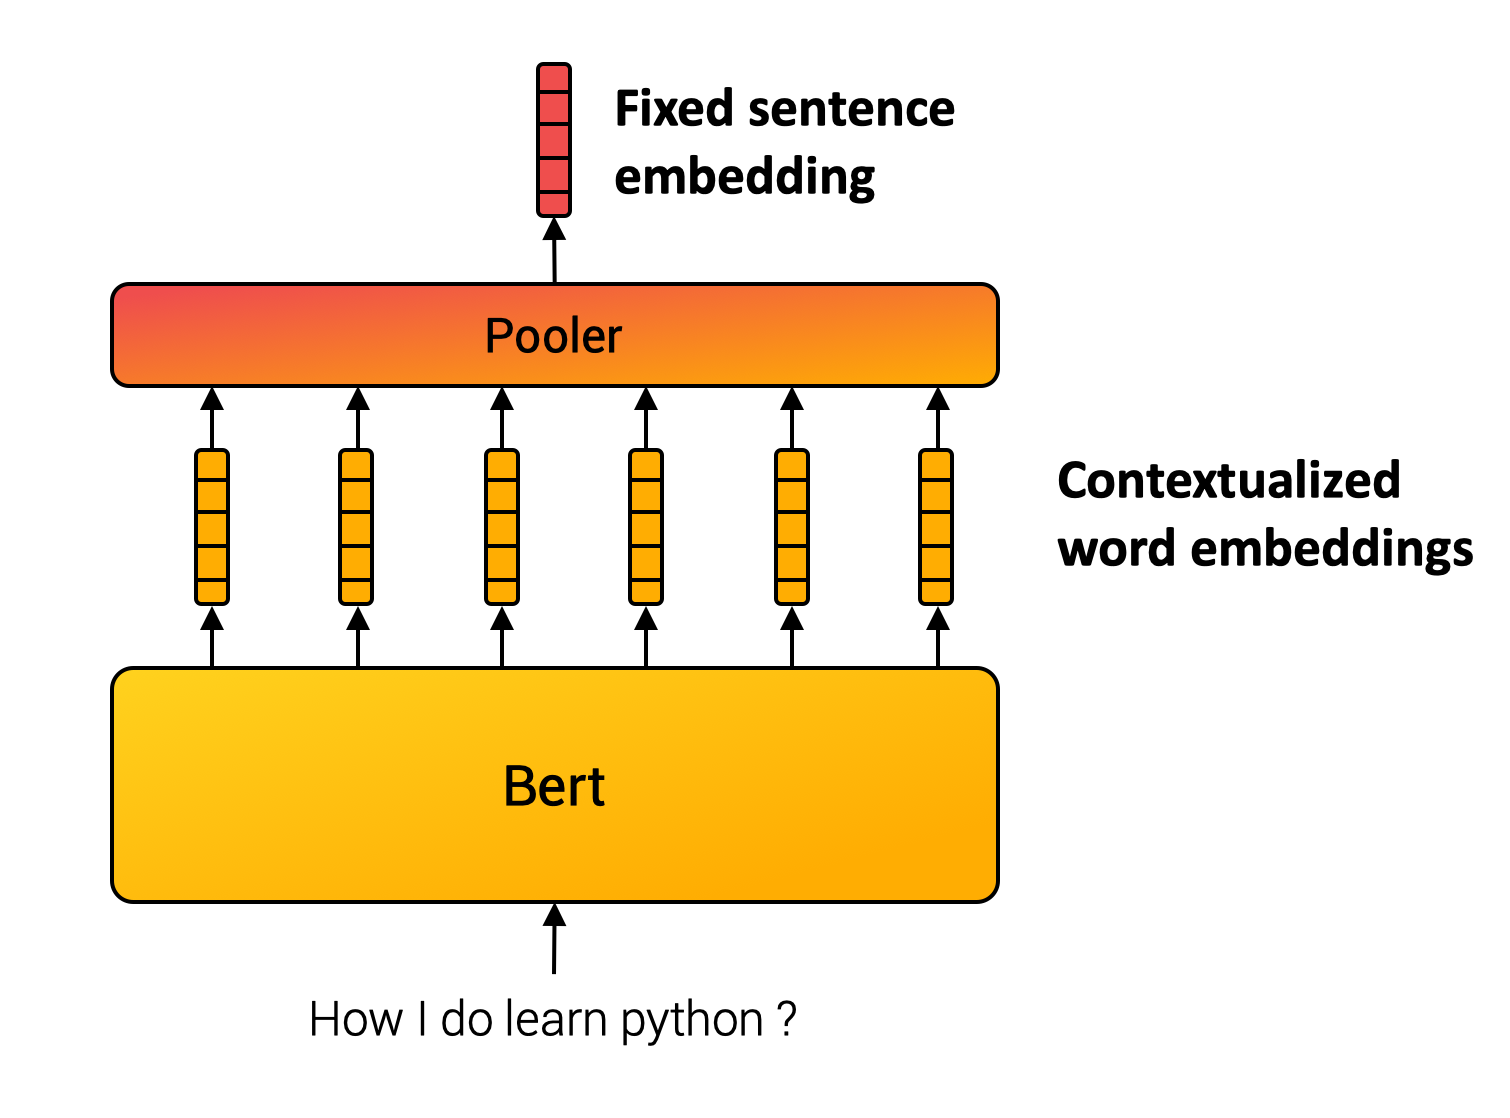
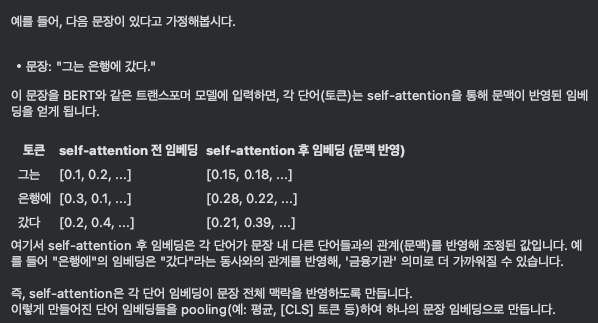

In [ ]:
# 예제 10.3 Sentence-Transformers 라이브러리로 바이 인코더 생성하기

from sentence_transformers import SentenceTransformer, models

# 사용할 BERT 모델
word_embedding_model = models.Transformer('klue/roberta-base')

# 풀링 층 차원 입력
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

# 두 모듈 결합하기
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model

- Pooling mode
  - 클래스 모드 (pooling_mode_cls_tokens)
    - [CLS] 토큰을 사용하여 문장 임베딩을 생성
  - 평균 모드 (pooling_mode_mean_tokens)
    - 모든 토큰의 임베딩을 평균내어 문장 임베딩을 생성
  - 최대 모드 (pooling_mode_max_tokens)
    - 모든 토큰의 임베딩 중 최대값을 사용하여 문장 임베딩을 생성

In [ ]:
test_model = SentenceTransformer(modules=[word_embedding_model])
tokenized = test_model.tokenize('잠이 안 옵니다')
for id in tokenized['input_ids']:
    print(test_model.tokenizer.convert_ids_to_tokens(id))

encoded = test_model.encode('잠이 안 옵니다', output_value='token_embeddings')
print(encoded)

In [ ]:
# 예제 10.3 - 1 클래스 모드
import torch


def class_pooling(model_output, attention_mask):
    """
    [CLS] 토큰을 사용한 클래스 모드
    :param model_output: 언어 모델의 출력
    :param attention_mask: 패딩 토큰의 위치를 확인할 수 있는 어텐션 마스크
    :return:
    """

    token_embeddings = model_output[0]  # 언어 모델의 출력 중 마지막 층의 출력만 사용
    cls_embeddings = token_embeddings[:, 0, :]  # [CLS] 토큰의 임베딩을 가져온다.
    return cls_embeddings  # [CLS] 토큰의 임베딩을 반환한다.


# 테스트
sentences = [
    "잠이 안 옵니다",
    "졸음이 옵니다",
    "기차가 옵니다"
]

model_output = (
    torch.tensor([
        [[1.0, 1.0], [1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [0.0, 0.0]],  # "[CLS] 잠이 안 옵니다"
        [[2.0, 2.0], [4.0, 1.0], [5.0, 2.0], [0.0, 0.0], [0.0, 0.0]],  # "[CLS] 졸음이 옵니다"
        [[3.0, 3.0], [6.0, 2.0], [7.0, 3.0], [0.0, 0.0], [0.0, 0.0]],  # "[CLS] 기차가 옵니다"
    ]),
)
attention_mask = torch.tensor([
    [1, 1, 1, 1, 0],  # "잠이 안 옵니다"
    [1, 1, 1, 0, 0],  # "졸음이 옵니다"
    [1, 1, 1, 0, 0]   # "기차가 옵니다"
])

class_pooling(model_output, attention_mask)

In [ ]:
# 예제 10.4 평균 모드
import torch


def mean_pooling(model_output, attention_mask):
    """
    평균 모드
    :param model_output: 언어 모델의 출력
    :param attention_mask: 패딩 토큰의 위치를 확인할 수 있는 어텐션 마스크
    :return:
    """

    token_embeddings = model_output[0]  # 언어 모델의 출력 중 마지막 층의 출력만 사용
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()  # 입력이 패딩 토큰인 부분은 평균 계산에서 무시하기 위해 input_mask_expanded를 만들고

    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)  # input_mask_expanded를 출력 임베딩에 곱해 준다.
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)  # 마지막으로 출력 임베딩의 합을 패딩 토큰이 아닌 실제 토큰 입력의 수로 나눠준다.
    return sum_embeddings / sum_mask  # 평균 계산


# 테스트
sentences = [
    "잠이 안 옵니다",
    "졸음이 옵니다",
    "기차가 옵니다"
]

model_output = (
    torch.tensor([
        [[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [0.0, 0.0]],  # "잠이 안 옵니다"
        [[4.0, 1.0], [5.0, 2.0], [0.0, 0.0], [0.0, 0.0]],  # "졸음이 옵니다"
        [[6.0, 2.0], [7.0, 3.0], [0.0, 0.0], [0.0, 0.0]],  # "기차가 옵니다"
    ]),
)
attention_mask = torch.tensor([
    [1, 1, 1, 0],  # "잠이 안 옵니다"
    [1, 1, 0, 0],  # "졸음이 옵니다"
    [1, 1, 0, 0]  # "기차가 옵니다"
])

mean_pooling(model_output, attention_mask)

In [ ]:
# 예제 10.5 최대 모드
def max_pooling(model_output, attention_mask):
    """
    최대 모드
    :param model_output: 언어 모델의 출력
    :param attention_mask: 패딩 토큰의 위치를 확인할 수 있는 어텐션 마스크
    :return:
    """

    token_embeddings = model_output[0]  # 언어 모델의 출력 중 마지막 층의 출력만 사용
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()  # 입력이 패딩 토큰인 부분은 평균 계산에서 무시하기 위해 input_mask_expanded를 만들고
    token_embeddings[input_mask_expanded == 0] = -1e9
    return torch.max(token_embeddings, 1)[0]

# 테스트
sentences = [
    "잠이 안 옵니다",
    "졸음이 옵니다",
    "기차가 옵니다"
]

model_output = (
    torch.tensor([
        [[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [0.0, 0.0]],  # "잠이 안 옵니다"
        [[4.0, 1.0], [5.0, 2.0], [0.0, 0.0], [0.0, 0.0]],  # "졸음이 옵니다"
        [[6.0, 2.0], [7.0, 3.0], [0.0, 0.0], [0.0, 0.0]],  # "기차가 옵니다"
    ]),
)
attention_mask = torch.tensor([
    [1, 1, 1, 0],  # "잠이 안 옵니다"
    [1, 1, 0, 0],  # "졸음이 옵니다"
    [1, 1, 0, 0]  # "기차가 옵니다"
])

max_pooling(model_output, attention_mask)

## 10.2.3 Sentence-Transformers로 텍스트와 이미지 임베딩 생성해 보기
- 문장 임베딩
- 이미지 임베딩

In [ ]:
# 예제 10.6 Sentence-Transformers로 텍스트와 이미지 임베딩 생성해 보기
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('snunlp/KR-SBERT-V40k-klueNLI-augSTS')

embs = model.encode(['잠이 안 옵니다', '졸음이 옵니다', '기차가 옵니다'])

cos_scores = util.cos_sim(embs, embs)
cos_scores

In [ ]:
# 예제 10.7 CLIP 모델을 활용한 이미지와 텍스트 임베딩 유사도 계산
from PIL import Image
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')

img_embs = model.encode([Image.open('resources/dog.jpg'), Image.open('resources/cat.jpg')])
text_embs = model.encode(['A dog on grass', 'Brown cat on yellow background'])

cos_scores = util.cos_sim(img_embs, text_embs)
cos_scores

## 10.2.4 오픈소스와 상업용 임베딩 모델 비교하기

- https://platform.openai.com/docs/guides/embeddings
- 아직까지는 책에 소개된 embedding 모델들이 그대로 사용되고 있음